# $$ \hspace{7.5cm} \text{Gaussian Process Regression With RBF: Implementation in Python}$$

## Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Load the CSV File

In [ ]:
df = pd.read_csv('/content/Crude Oil WTI Futures Historical Data.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,07/29/2022,96.75,95.42,99.75,94.59,116.64K,2.22%
1,07/28/2022,94.65,96.09,97.82,94.28,96.14K,-0.67%
2,07/27/2022,95.29,93.51,96.53,92.30,105.40K,2.59%
3,07/26/2022,92.88,93.95,96.60,92.64,89.07K,-1.63%
4,07/25/2022,94.42,92.83,94.62,90.79,92.70K,2.15%
...,...,...,...,...,...,...,...
206,10/19/2021,82.44,81.58,82.99,81.08,531.47K,0.92%
207,10/18/2021,81.69,82.00,83.18,81.21,501.07K,-0.05%
208,10/15/2021,81.73,80.93,82.00,80.86,284.73K,1.19%
209,10/14/2021,80.77,79.94,81.14,79.79,300.57K,1.19%


In [ ]:
df = df.iloc[::-1].reset_index(drop=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,10/13/2021,79.82,79.83,80.36,78.78,304.96K,-0.13%
1,10/14/2021,80.77,79.94,81.14,79.79,300.57K,1.19%
2,10/15/2021,81.73,80.93,82.00,80.86,284.73K,1.19%
3,10/18/2021,81.69,82.00,83.18,81.21,501.07K,-0.05%
4,10/19/2021,82.44,81.58,82.99,81.08,531.47K,0.92%
...,...,...,...,...,...,...,...
206,07/25/2022,94.42,92.83,94.62,90.79,92.70K,2.15%
207,07/26/2022,92.88,93.95,96.60,92.64,89.07K,-1.63%
208,07/27/2022,95.29,93.51,96.53,92.30,105.40K,2.59%
209,07/28/2022,94.65,96.09,97.82,94.28,96.14K,-0.67%


In [ ]:
# Normalize using index (equal spacing from 0 to 1)
n = len(df)
df['date_scaled'] = df.index / (n - 1)
df

,Date,Price,Open,High,Low,Vol.,Change %,date_scaled
0,10/13/2021,79.82,79.83,80.36,78.78,304.96K,-0.13%,0.000000
1,10/14/2021,80.77,79.94,81.14,79.79,300.57K,1.19%,0.004762
2,10/15/2021,81.73,80.93,82.00,80.86,284.73K,1.19%,0.009524
3,10/18/2021,81.69,82.00,83.18,81.21,501.07K,-0.05%,0.014286
4,10/19/2021,82.44,81.58,82.99,81.08,531.47K,0.92%,0.019048
...,...,...,...,...,...,...,...,...
206,07/25/2022,94.42,92.83,94.62,90.79,92.70K,2.15%,0.980952
207,07/26/2022,92.88,93.95,96.60,92.64,89.07K,-1.63%,0.985714
208,07/27/2022,95.29,93.51,96.53,92.30,105.40K,2.59%,0.990476
209,07/28/2022,94.65,96.09,97.82,94.28,96.14K,-0.67%,0.995238


## Generate Training & Test Data

In [ ]:
X = df['date_scaled'].to_numpy()
Y = df['High'].to_numpy()

xB = np.linspace(0, 1, 11)
indices = np.linspace(0, len(Y) - 1, 11, dtype=int)
yB = Y[indices]

# Boolean mask using isclose to match scaled dates with xB
train_mask = np.isclose(X[:, None], xB, atol=1e-6).any(axis=1)

# Train/test split
X_train, Y_train = X[train_mask], Y[train_mask]
X_test, Y_test = X[~train_mask], Y[~train_mask]

# Debug
print("X_train:", X_train)
print("Y_train:", Y_train)
print("X_test:", X_test)
print("Y_test:", Y_test)

X_train: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Y_train: [ 80.36  80.95  72.15  80.95  90.07 124.98 102.63 109.53 117.77 106.26
  99.75]
X_test: [0.0047619  0.00952381 0.01428571 0.01904762 0.02380952 0.02857143
 0.03333333 0.03809524 0.04285714 0.04761905 0.05238095 0.05714286
 0.06190476 0.06666667 0.07142857 0.07619048 0.08095238 0.08571429
 0.09047619 0.0952381  0.1047619  0.10952381 0.11428571 0.11904762
 0.12380952 0.12857143 0.13333333 0.13809524 0.14285714 0.14761905
 0.15238095 0.15714286 0.16190476 0.16666667 0.17142857 0.17619048
 0.18095238 0.18571429 0.19047619 0.1952381  0.2047619  0.20952381
 0.21428571 0.21904762 0.22380952 0.22857143 0.23333333 0.23809524
 0.24285714 0.24761905 0.25238095 0.25714286 0.26190476 0.26666667
 0.27142857 0.27619048 0.28095238 0.28571429 0.29047619 0.2952381
 0.3047619  0.30952381 0.31428571 0.31904762 0.32380952 0.32857143
 0.33333333 0.33809524 0.34285714 0.34761905 0.35238095 0.35714286
 0.36190476 0.36666667 0.37142857 0.37619048 

## Plot Training & Test Data

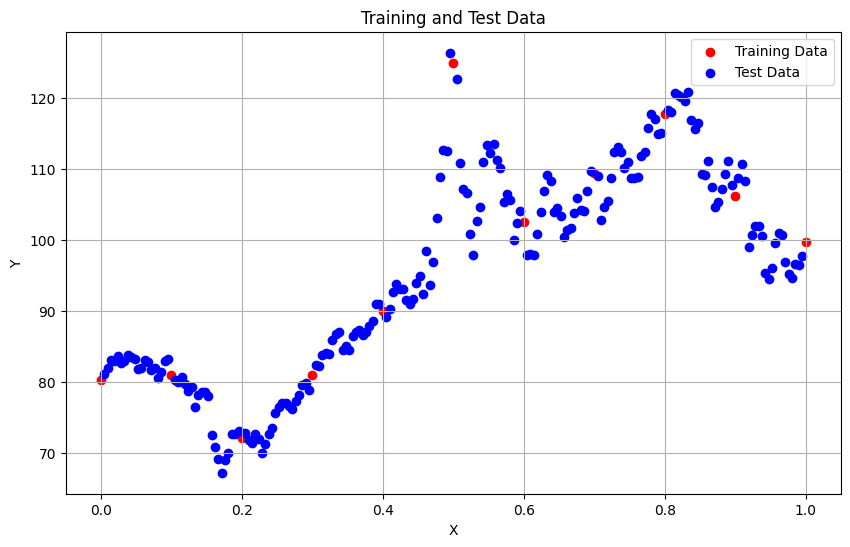

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, color='red', label='Training Data')
plt.scatter(X_test, Y_test, color='blue', label='Test Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training and Test Data')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('training_test_data.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Define the Priestley-Chao Mean Function

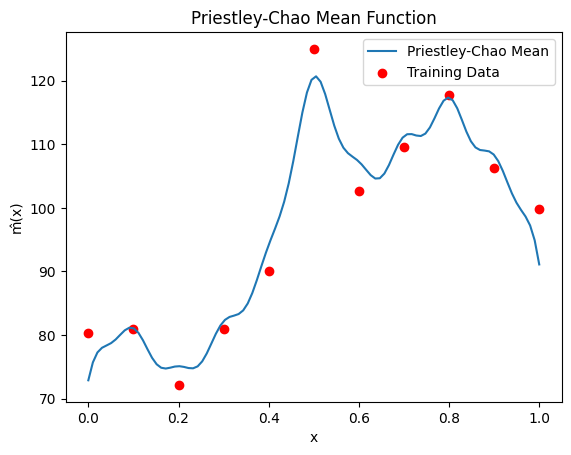

In [ ]:
def priestley_chao_mean(x, xB, yB, d=0.05):
    coeff = 1 / (10 * np.sqrt(2 * np.pi) * d)  # Constant coefficient
    return coeff * np.sum(yB[:, None] * np.exp(-((x - xB[:, None])**2) / (2 * d**2)), axis=0)

# Compute mean function values
x_test = np.linspace(0, 1, 100)  # Test points
m_values = priestley_chao_mean(x_test, xB, yB, d=0.05)

# Plot the results
plt.plot(x_test, m_values, label="Priestley-Chao Mean")
plt.scatter(xB, yB, color='red', label="Training Data")
plt.legend()
plt.xlabel("x")
plt.ylabel("m̂(x)")
plt.title("Priestley-Chao Mean Function")

# Save the figure
plt.savefig("priestley_chao_mean.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

## Compute Residual Errors

In [ ]:
e_s=np.array([])
for i in range(11):
  e_s=np.append(e_s,yB[i]-priestley_chao_mean(xB[i],xB,yB,d=0.05))

In [ ]:
# Calculate the variance of e_s
variance_e_s = np.var(e_s)
best_sigma2 = variance_e_s
print("Variance of e_s:", variance_e_s)

Variance of e_s: 18.568677878995768


## Define RBF Kernel Function

In [ ]:
def kernel_function(x, x_prime, theta, h):
  return theta * np.exp(-((x - x_prime)**2) / (2 * h**2))

## Install Optuna (Hyperparameter Optimization)

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.6 MB/s eta 0:00:00


## Hyperparameter Tuning with Optuna

In [ ]:
import optuna

def log_marginal_likelihood(trial):
    """
    Objective function for Optuna: Maximizes the log marginal likelihood.

    log p(e* | x) = -0.5 * e*^T * {K(x, x) + sigma^2 * I}^-1 * e*
                    - 0.5 * log |K(x, x) + sigma^2 * I|
                    - N/2 * log(2π)
    """

    # Suggest hyperparameters
    theta = trial.suggest_float("theta", 0.65, 0.67, log=True)
    h = trial.suggest_float("h", 4.85, 4.87, log=True)

    # Construct kernel matrix K(x, x)
    N = len(xB)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = kernel_function(xB[i], xB[j], theta, h)

    # Compute K + sigma^2 * I
    K_plus_sigma = K + best_sigma2 * np.eye(N)

    try:
        # Compute inverse directly
        K_inv = np.linalg.inv(K_plus_sigma)

        # Compute log marginal likelihood
        log_marginal_likelihood = (
            -0.5 * np.dot(e_s.T, np.dot(K_inv, e_s))
            - 0.5 * np.log(np.linalg.det(K_plus_sigma))
            - N / 2 * np.log(2 * np.pi)
        )

    except np.linalg.LinAlgError:
        return -np.inf

    return log_marginal_likelihood

# Set random seed for reproducibility
seed_value = 42
sampler = optuna.samplers.TPESampler(seed=seed_value)

# Run Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(log_marginal_likelihood, n_trials=4000)

# Print best results
print("Best hyperparameters:", study.best_params)
print("Best log marginal likelihood:", study.best_value)

# Extract best hyperparameters
best_theta = study.best_params['theta']
best_h = study.best_params['h']

print(f"Optimized theta: {best_theta}, h: {best_h}")

[I 2025-05-14 17:19:17,746] A new study created in memory with name: no-name-ea1da559-4d84-42dc-b5cd-20738dddbabc
[I 2025-05-14 17:19:17,750] Trial 0 finished with value: -31.872889987334474 and parameters: {'theta': 0.6574199003653882, 'h': 4.869012356677711}. Best is trial 0 with value: -31.872889987334474.
[I 2025-05-14 17:19:17,751] Trial 1 finished with value: -31.874326996834874 and parameters: {'theta': 0.6645802877274849, 'h': 4.861963280824789}. Best is trial 0 with value: -31.872889987334474.
[I 2025-05-14 17:19:17,752] Trial 2 finished with value: -31.872021861594487 and parameters: {'theta': 0.6530806067495545, 'h': 4.853114474840369}. Best is trial 2 with value: -31.872021861594487.
[I 2025-05-14 17:19:17,754] Trial 3 finished with value: -31.871629224791548 and parameters: {'theta': 0.6511451662988216, 'h': 4.8673187503476365}. Best is trial 3 with value: -31.871629224791548.
[I 2025-05-14 17:19:17,756] Trial 4 finished with value: -31.873799599521277 and parameters: {'th

Best hyperparameters: {'theta': 0.6500000051178606, 'h': 4.869997633178887}
Best log marginal likelihood: -31.871398105140546
Optimized theta: 0.6500000051178606, h: 4.869997633178887


## Implement Gaussian Process Regression

In [ ]:
def gaussian_process_regression(x_pred, xB, yB, best_theta, best_h, best_sigma2):
    """
    Performs Gaussian Process Regression using the given training data and kernel hyperparameters.
    Includes Priestley-Chao mean adjustment and numerically stable predictions.
    """
    N = len(xB)
    e_s = yB - priestley_chao_mean(xB, xB, yB, d=0.05)

    # Kernel matrix K(xB, xB)
    K = np.array([[kernel_function(xB[i], xB[j], best_theta, best_h) for j in range(N)] for i in range(N)])
    K_plus_sigma = K + best_sigma2 * np.eye(N)

    # Kernel between x_pred and training points xB
    k_star = np.array([[kernel_function(x_pred[i], xB[j], best_theta, best_h) for j in range(N)] for i in range(len(x_pred))])

    # Kernel matrix K(x_pred, x_pred)
    k_star_star = np.array([[kernel_function(x_pred[i], x_pred[j], best_theta, best_h) for j in range(len(x_pred))] for i in range(len(x_pred))])

    try:
        # Cholesky decomposition for numerical stability
        L = np.linalg.cholesky(K_plus_sigma)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, e_s))

        # Predictive mean
        mean_prediction = priestley_chao_mean(x_pred, xB, yB, d=0.05) + k_star @ alpha

        # Predictive variance (diagonal only)
        v = np.linalg.solve(L, k_star.T)
        variance_prediction = np.diag(k_star_star - v.T @ v)

        return mean_prediction, variance_prediction

    except np.linalg.LinAlgError:
        print("Matrix decomposition failed.")
        return None, None

## Plot GPR Predictions

Evaluation Metrics:
Mean Squared Error (MSE): 28.4172
Mean Absolute Error (MAE): 3.8809


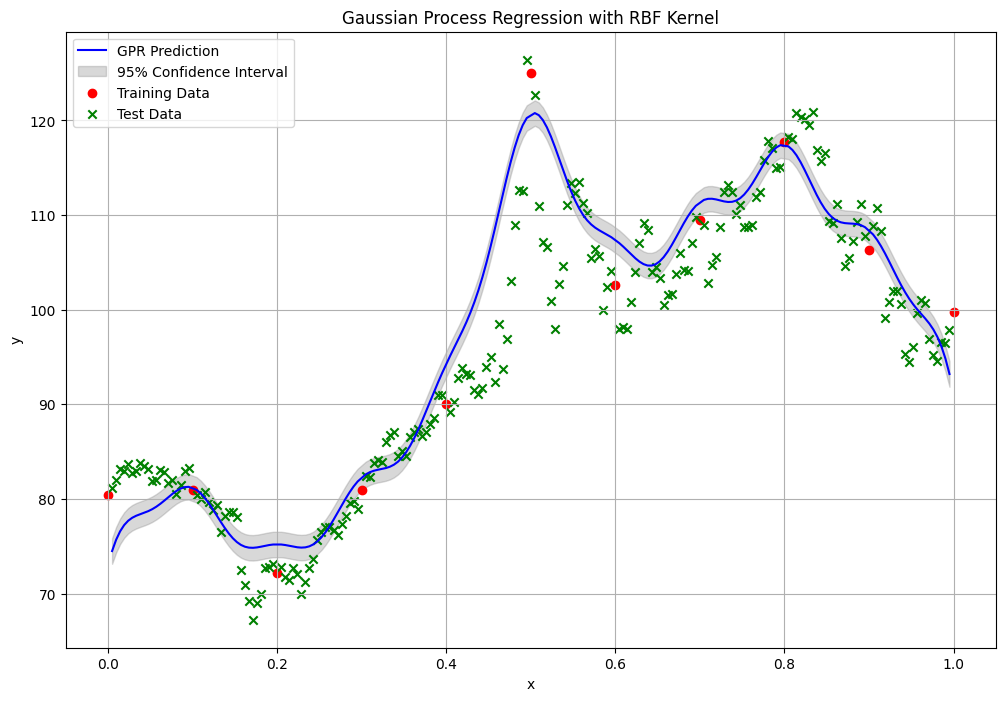

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate test points (Use only X_test for prediction)
x_pred = X_test

# Gaussian Process Regression prediction
mean_prediction, variance_prediction = gaussian_process_regression(x_pred, xB, yB, best_theta, best_h, best_sigma2)

if mean_prediction is not None:
    # Compute standard deviation
    std_dev_prediction = np.sqrt(variance_prediction)

    # Compute confidence interval bounds
    upper_bound = mean_prediction + 1.96 * std_dev_prediction
    lower_bound = mean_prediction - 1.96 * std_dev_prediction

    # Evaluation section
    mse = mean_squared_error(Y_test, mean_prediction)
    mae = mean_absolute_error(Y_test, mean_prediction)

    print("Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Optional: sort for clean plotting
    sort_idx = np.argsort(x_pred)
    x_sorted = x_pred[sort_idx]
    mean_sorted = mean_prediction[sort_idx]
    upper_sorted = upper_bound[sort_idx]
    lower_sorted = lower_bound[sort_idx]

    # Plot results
    plt.figure(figsize=(12, 8))

    # GPR Mean Prediction Line
    plt.plot(x_sorted, mean_sorted, label="GPR Prediction", color='blue')

    # Confidence Interval
    plt.fill_between(x_sorted, lower_sorted, upper_sorted, color='gray', alpha=0.3, label="95% Confidence Interval")

    # Training Data
    plt.scatter(xB, yB, color='red', label="Training Data", marker='o')

    # Test Data
    plt.scatter(X_test, Y_test, color='green', label="Test Data", marker='x')

    # Formatting
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Gaussian Process Regression with RBF Kernel")
    plt.legend()
    plt.grid(True)
    plt.savefig("gpr_prediction.png", dpi=300, bbox_inches="tight")
    plt.show()